In [2]:
import os
import tempfile
import numpy as np
import pandas as pd
import qiime2 as q2
from qiime2 import Artifact
from qiime2 import Metadata
import itertools
from biom import Table
from skbio import TreeNode
from skbio import DistanceMatrix
from skbio import OrdinationResults
from scipy.stats import ttest_ind, ttest_1samp, ranksums
from biom import load_table, Table
from qiime2.plugins.feature_table.methods import rarefy
from skbio.stats.distance import permanova, anosim
from qiime2.plugins.deicode.actions import rpca
from qiime2.plugins.emperor.actions import biplot, plot
from qiime2.plugins.qurro.actions import (loading_plot,
                                          differential_plot,
                                          qarcoal)
from qiime2.plugins.diversity.actions import beta_group_significance
from qiime2.plugins.songbird.actions import multinomial, summarize_paired

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import parallel_coordinates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import to_hex

plt.style.use('ggplot')
%matplotlib inline

In [3]:
"""

Define some functions to plot with.

"""


def pairwise_ttest(df, group_column, value,
                   combinations=[],
                   correction=True):

    # get combos
    if len(combinations) == 0:
        order = sorted(set(df[group_column]))
        combinations = itertools.combinations(order, 2)
        combinations = list(combinations)
    pairwisedf = []
    max_order = {}
    for c1, c2 in combinations:
        # t-test
        t1 = df[df[group_column].isin([c1])][value].values
        t2 = df[df[group_column].isin([c2])][value].values
        t_res = ttest_ind(t1, t2, equal_var=True)   
        # tdf
        t_res = pd.DataFrame(t_res,
                             ['test-stat','P'],
                             [c1 + ' vs. ' + c2])
        pairwisedf.append(t_res)
        max_= max(max(t1),max(t2))
        max_order[c1 + ' vs. ' + c2] = max_
    # merge
    pairwisedf = pd.concat(pairwisedf, axis=1).T
    # bonfer correct
    if correction:
        pairwisedf['P'] = pairwisedf['P'] * len(combinations)
    return pairwisedf, max_order


def swarmbox_plot(df, ax, y, x, order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  data=df,
                  palette=palette,
                  order=order,
                  ax=ax, s=6)
    sns.boxplot(y=y, x=x,
                data=df,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=26, color='black')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax

def swarmbox_plot_hue(df, ax, y, x, hue, order,
                      hue_order, palette='Set1'):
    
    # plotting.
    sns.swarmplot(y=y, x=x,
                  hue = hue,
                  dodge=True,
                  data=df,
                  hue_order=hue_order,
                  palette=palette,
                  order=order,
                  ax=ax, s=10)
    sns.boxplot(y=y, x=x,
                hue=hue,
                data=df,
                hue_order=hue_order,
                order=order,
                ax=ax,
                palette=palette)
    # patches
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_xlabel('', fontsize=25)
    ax.set_ylabel('%s ($\\mu$M)' % y.capitalize(),
                  fontsize=26, color='black')
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    ax.tick_params(axis='x', colors='black')
    
    return ax

def temporal_plot(x_axis, y_axis, df, ax, title, x_label, y_label,
                  title_fontsize, x_fontsize, y_fontsize, hue=None,
                  style=None, size=None, min_x = 0, max_x = 35, err_style='band', 
                  ci=95, cmap='tab10', style_order=None, dashes_=True,
                  style_order_ = ['CSseed','Vag','CS']):

    """

    This wrapper creates beautiful timeseries plots using
    seaborn and matplotlib. 

    Parameters
    ----------
    x_axis : str, required
        X-axis catagory in dataframe -- data
        
    y_axis : str, required
        y-axis catagory in dataframe -- data
        
    df : dataframe, required
        dataframe of data to plot
    
    ax : matplotlib figure object, required
        panel object from matplotlib figure 
    
    title : str, required
        panel title
    
    x_label : str, required
        x label panel title
    
    y_label : str, required
        y label panel title
        
    title_fontsize : int, required
    x_fontsize : int, required
    y_fontsize : int, required
        font sizes 
    
    hue : str, optional
        color by catagory in dataframe -- data
        
    style : str, optional
        style by catagory in dataframe -- data
    
    Returns
    ----------
    matplotlib figure object

    """
    

    # Lineplot across time 
    sns.lineplot(x=x_axis,
                 y=y_axis,
                 hue=hue,
                 style=style,
                 dashes=dashes_,
                 style_order=style_order_,
                 ci=ci,
                 sort=True,
                 markers=style_order,
                 estimator=np.mean,
                 err_style=err_style,
                 palette=cmap,
                 data=df,
                 ax=ax)
    
    
    
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel(x_label, color='#000000',
                  fontsize=x_fontsize)
    ax.set_ylabel(y_label, color='#000000',
                  fontsize=y_fontsize, labelpad=0)
    
    # remove all grids, backrounds etc ...
    ax.legend_.remove()        
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(min_x, max_x)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    return ax

# Part 1

In [105]:
mf = pd.read_csv('data/mapping-files/mapping-etoh-ctrl.tsv',
                     sep='\t', index_col=0)
mf.index.name = '#SampleID'
mf.index = mf.index.astype(str)
q2mf = q2.Metadata(mf)


In [106]:
bin_abund = pd.read_csv('data/bin-grouped-tables/bin-raw-counts.tsv',
                        sep='\t', index_col=0)
len(bin_abund.columns)

46

In [107]:
tax_transctrp = pd.read_csv('data/bin-stats/bin-taxonomy.tsv',
                            sep='\t', index_col=0, header=None)
tax_transctrp.index = [x.split('.fa')[0] for x in tax_transctrp.index]
bin_size = pd.read_csv('data/bin-grouped-tables/bin-size.tsv',
                        sep='\t', index_col=0)

bin_abund = pd.read_csv('data/bin-grouped-tables/bin-raw-counts.tsv',
                        sep='\t', index_col=0)
bin_abund = bin_abund[set(mf.index) & set(bin_abund.columns)]
bin_abund = bin_abund.T[bin_abund.sum(0) > 500].T
bin_abund = bin_abund[bin_abund.sum(1) > 10]
btbin_abund = Table(bin_abund.values, bin_abund.index, bin_abund.columns)
q2bin_abund = q2.Artifact.import_data('FeatureTable[Frequency]', btbin_abund)

bin_transcript = pd.read_csv('data/bin-grouped-tables/bin-transcription-raw-counts.tsv',
                             sep='\t', index_col=0)
bin_transcript = bin_transcript[set(mf.index) & set(bin_transcript.columns)]
bin_transcript = bin_transcript.T[bin_transcript.sum(0) > 500].T
bin_transcript = bin_transcript[bin_transcript.sum(1) > 10]
btbin_transcript = Table(bin_transcript.values, bin_transcript.index, bin_transcript.columns)
q2bin_transcript = q2.Artifact.import_data('FeatureTable[Frequency]', btbin_transcript)



In [108]:
binabund = rpca(q2bin_abund,
                n_components=6,
                min_feature_frequency=10,
                min_sample_count=0)

bintrnscrpt = rpca(q2bin_transcript,
                   n_components=6,
                   min_feature_frequency=10,
                   min_sample_count=0)

binabund.biplot.save('results/bins/binabund-biplot.qza')
bintrnscrpt.biplot.save('results/bins/bintrnscrpt-biplot.qza')
binabund.distance_matrix.save('results/bins/binabund-distance-matrix.qza')
bintrnscrpt.distance_matrix.save('results/bins/bintrnscrpt-distance-matrix.qza')


'results/bins/bintrnscrpt-distance-matrix.qza'

In [109]:
dist_ = binabund.distance_matrix.view(DistanceMatrix)
permanova(dist_, mf.loc[dist_.ids, 'treatment'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      14
number of groups                  2
test statistic              2.95357
p-value                       0.003
number of permutations          999
Name: PERMANOVA results, dtype: object

In [110]:
dist_ = bintrnscrpt.distance_matrix.view(DistanceMatrix)
permanova(dist_, mf.loc[dist_.ids, 'treatment'], permutations=4000)


method name                PERMANOVA
test statistic name         pseudo-F
sample size                       13
number of groups                   2
test statistic               2.46592
p-value                   0.00424894
number of permutations          4000
Name: PERMANOVA results, dtype: object

In [111]:

binabund_biplot = binabund.biplot.view(OrdinationResults)
bintrnscrpt_biplot = bintrnscrpt.biplot.view(OrdinationResults)


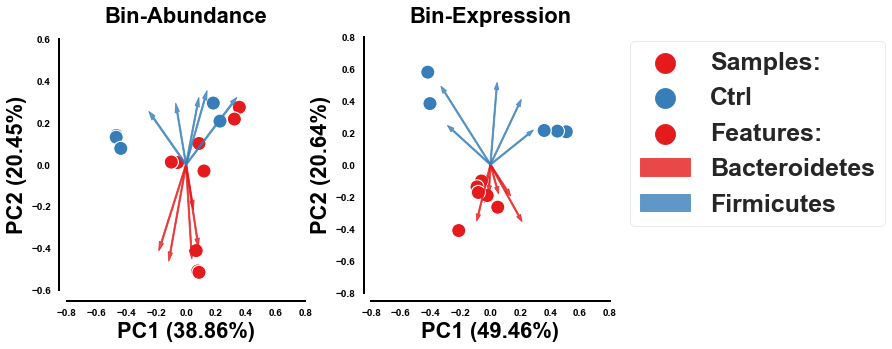

In [112]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

pallet_ = {'EtOH':'#e41a1c',
           'Ctrl':'#377eb8'}
taxmap = {'Bacteroidetes':'#e41a1c',
          'Firmicutes':'#377eb8',
          'Proteobacteria':'#4daf4a',
          'Actinobacteria':'#984ea3'}
n_features = 10
lr_feats = 5
tax_level = 2
lr_dfs = {}

fig, axn = plt.subplots(1,2,figsize=(10,5),
                        sharex=False,
                        sharey=False)

for ord_, ax, title_ in zip([binabund_biplot, bintrnscrpt_biplot],
                            axn.flatten(),
                            ['Bin-Abundance','Bin-Expression']):
    
    
    # fix so direction is the same between figures
    # (directionality doesn't matter really but it nice visually)
    ord_tmp_samp = ord_.samples.copy()
    s_ord = pd.concat([ord_tmp_samp, mf],
                      axis=1, sort=True)
    if s_ord.groupby('treatment').mean().loc['EtOH',1] > 0:
        factor = -1
    else:
        factor = 1
    s_ord[[0,1,2]] *= factor


    sns.scatterplot(0, 1,
                    hue='treatment',
                    s=200,
                    data=s_ord,
                    ax=ax,
                    palette=pallet_)
    ax.legend_.remove()
    ax.set_title(title_, fontsize=22, weight='bold', color='black')
    ax.set_xlabel('PC1 (%.2f%%)' % (ord_.proportion_explained[0]*100),
                  fontsize=22, weight='bold', color='black')
    ax.set_ylabel('PC2 (%.2f%%)' % (ord_.proportion_explained[1]*100),
                  fontsize=22, weight='bold', color='black')
    
    # add feature arrows 
    ord_tmp_feat = ord_.features
    f_ord = pd.concat([ord_tmp_feat * 2,
                       tax_transctrp.rename({1:'taxonomy'}, axis=1)],
                      axis=1, sort=True)
    f_ord['taxonomy'] = f_ord.index + ';' + f_ord['taxonomy']
    f_ord['taxonomy'] = [x.split(';')[tax_level] if len(x.split(';')) > tax_level else np.nan
                         for x in f_ord['taxonomy']]
    f_ord = f_ord.dropna(subset=['taxonomy', 0])
    f_ord = f_ord[~f_ord.taxonomy.isin(['Candidatus Melainabacteria'])]
    f_ord["mag"] = np.linalg.norm(f_ord[[0,1]], axis=1) * f_ord[1]
    f_ord = f_ord.sort_values("mag")
    f_ord_plot = pd.concat([f_ord[f_ord.taxonomy.isin(['Bacteroidetes'])].iloc[:n_features//2, :],
                            f_ord[f_ord.taxonomy.isin(['Firmicutes'])].iloc[-n_features//2:, :]])
    f_ord_plot['color'] = [taxmap[v] for v in f_ord_plot.taxonomy]

    # add arrows 
    annots = []
    seqs = []
    for i in f_ord_plot.index:
        annots.append(ax.arrow(0, 0,
                               f_ord_plot.loc[i,0],
                               f_ord_plot.loc[i,1],
                               color=f_ord_plot.loc[i,'color'],
                               alpha=0.8,
                               length_includes_head=True,
                               head_width=.03, width=.009))
        seqs.append(f_ord_plot.loc[i,'taxonomy'])
        
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
        
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(10)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(10)
    
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(2)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
            
    if title_ == 'Bin-Expression':
        ax.set_ylim(-0.85, 0.85)
        ax.set_xlim(-0.85, 0.85)
        ax.spines['left'].set_bounds(-0.8, 0.8)
        ax.spines['bottom'].set_bounds(-0.8, 0.8)
    else:
        ax.set_ylim(-0.65, 0.65)
        ax.set_xlim(-0.85, 0.85)
        ax.spines['left'].set_bounds(-0.6, 0.6)
        ax.spines['bottom'].set_bounds(-0.8, 0.8)
        
set_annot = {k:v for v, k in zip(annots, seqs)}
# generate legend from last iterations     
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend([handles[0]] + handles[1:] \
                   + [handles[0]] + list(set_annot.values()),
                   ['Samples:'] + labels[1:] + \
                   ['Features:'] + list(set_annot.keys()), 
                   loc=2, 
                         bbox_to_anchor=(1.0, 1.0),
                         prop={'size':25, 'weight':'bold'},
                         fancybox=True, framealpha=0.5,
                         ncol=1, markerscale=2, facecolor="white")

# save the figure to file
plt.savefig('results/figures/metaG-metaT-etoh-ctrl-rpca.pdf',dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

In [113]:
f_ord_plot

,0,1,2,3,4,5,taxonomy,mag,color
bin.482,0.212291,-0.357400,0.159457,-0.219793,0.114977,0.032850,Bacteroidetes,-0.148570,#e41a1c
bin.515,-0.091941,-0.353933,-0.157022,0.195339,0.048784,0.128709,Bacteroidetes,-0.129426,#e41a1c
bin.19,0.135944,-0.196841,0.121611,-0.100089,-0.016033,0.026107,Bacteroidetes,-0.047089,#e41a1c
bin.283,0.054973,-0.183083,-0.180041,0.078480,0.147338,0.038564,Bacteroidetes,-0.034998,#e41a1c
bin.269,-0.010439,-0.176920,0.116740,-0.290469,-0.261433,0.243220,Bacteroidetes,-0.031355,#e41a1c
bin.550,0.288289,0.216193,-0.090632,-0.069264,0.094192,-0.124893,Firmicutes,0.077904,#377eb8
bin.241,-0.288702,0.245347,-0.282179,-0.195525,-0.248145,-0.070938,Firmicutes,0.092955,#377eb8
bin.356,0.207241,0.408635,0.105068,0.008494,-0.209844,0.075406,Firmicutes,0.187230,#377eb8
bin.455,0.044691,0.515014,-0.151583,-0.096727,-0.171859,-0.151194,Firmicutes,0.266236,#377eb8
bin.525,-0.332340,0.491188,0.237728,0.327282,-0.393769,0.269803,Firmicutes,0.291302,#377eb8


In [31]:
enter = [k for k, v in tax_transctrp[1].items() if 'Enterococcaceae' in v]
bacter = [k for k, v in tax_transctrp[1].items() if 'Bacteroidetes' in v]

bin_transcript_ = bin_transcript+1
bin_abund_ = bin_abund+1

abdundlr = pd.DataFrame(np.log(bin_abund_.loc[enter, :].sum())\
                        - np.log(bin_abund_.loc[bacter, :].sum()).sort_index(),
                        columns=['log_ratio_abundance'])
expreslr = pd.DataFrame(np.log(bin_transcript_.loc[enter, :].sum())\
                        - np.log(bin_transcript_.loc[bacter, :].sum()).sort_index(),
                       columns=['log_ratio_expression'])
mf_lr = pd.concat([expreslr, abdundlr, mf], axis=1,sort=False).sort_values('treatment')
mf_lr.loc[~np.isfinite(mf_lr['log_ratio_expression'].values), 'log_ratio_expression'] = np.nan
mf_lr.loc[~np.isfinite(mf_lr['log_ratio_abundance'].values), 'log_ratio_abundance'] = np.nan
mf_lr.head(3)


,log_ratio_expression,log_ratio_abundance,treatment
624,-6.255110,-9.090788,Ctrl
626,-6.808303,-9.511921,Ctrl
627,-7.017506,-9.222808,Ctrl


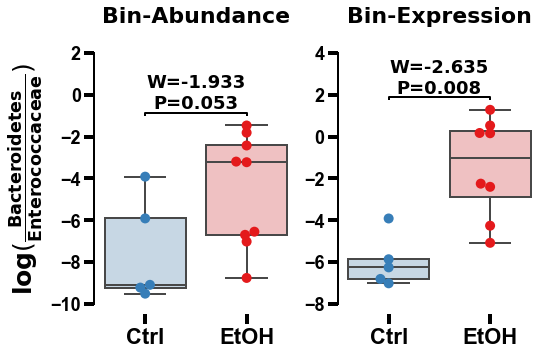

In [33]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 25}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 26
plt.rcParams['ytick.labelsize'] = 12
pallet_ = {'Ctrl':'#377eb8',
           'EtOH':'#e41a1c'}

fig, axn = plt.subplots(1,2, figsize=(8,5))

for (title_, col_), ax in zip({'Bin-Abundance': 'log_ratio_abundance',
                               'Bin-Expression': 'log_ratio_expression'}.items(),
                              axn.flatten()):

    # plotting.
    sns.swarmplot(y=col_, x='treatment',
                data=mf_lr, palette=pallet_,
                ax=ax, s=10, order = ['Ctrl','EtOH'])
    sns.boxplot(y=col_,x='treatment',
                data=mf_lr,
                ax=ax, palette=pallet_, order = ['Ctrl','EtOH'])
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .3))
    # title etc ... 
    ax.set_title(title_, y=1.05, fontsize=22, color='black', weight='bold')
    ax.set_xlabel('', fontsize=25)
    if title_ == 'Bin-Abundance':
        ax.set_ylabel('log$(\\frac{ {%s}}{\\mathbf{%s}})$' % ('Bacteroidetes',
                                                 'Enterococcaceae') ,
                              fontsize=25, color='black', weight='bold')
    else:
        ax.set_ylabel('')
    # statistical annotation
    t_res = ranksums(mf_lr[mf_lr.treatment.isin(['Ctrl'])][col_].dropna().values,
                      mf_lr[mf_lr.treatment.isin(['EtOH'])][col_].dropna().values)
    p_ = 'W=%.3f\nP=%.3f' % (t_res.statistic, t_res.pvalue)
    x1, x2 = 0, 1   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = mf_lr[col_].max() + .5, .1, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            fontsize=18, color='black', weight='bold')
    #ps.append(t_res.pvalue)
    # remove all grids, backrounds etc ...
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
        
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(22)
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight("bold")
        tick.set_color("black")
        tick.set_fontsize(18)
    
    for sp_i in ax.spines.values():
        sp_i.set_linewidth(2)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('black')
            
    if title_ != 'Bin-Expression':
        ax.set_ylim(-10.5, 2.5)
        ax.spines['left'].set_bounds(-10, 2)
    else:
        ax.set_ylim(-8.5, 4.5)
        ax.spines['left'].set_bounds(-8, 4)
    ax.tick_params(axis='y', colors='black', width=4, length=10)
    ax.tick_params(axis='x', colors='black', width=4, length=10)
    
# save the figure to file
plt.savefig('results/figures/metaG-metaT-lr-bacter-firm.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')
plt.show()

# Part 2

In [38]:
mf = pd.read_csv('data/mapping-files/mapping-glu-gta.tsv',
                     sep='\t', index_col=0)
mf.index.name = '#SampleID'
mf.index = mf.index.astype(str)
mf = mf.drop(['5526'], axis=0)
mf['treatment'] = [x.replace('Alcohol','Ethanol') for x in mf.treatment]
q2mf = q2.Metadata(mf)


In [39]:
tax_transctrp = pd.read_csv('data/bin-stats/bin-taxonomy.tsv',
                            sep='\t', index_col=0, header=None)
tax_transctrp.index = [x.split('.fa')[0] for x in tax_transctrp.index]
bin_size = pd.read_csv('data/bin-grouped-tables/bin-size.tsv',
                        sep='\t', index_col=0)

bin_abund = pd.read_csv('data/bin-grouped-tables/bin-raw-counts.tsv',
                        sep='\t', index_col=0)
bin_abund = bin_abund[set(mf.index) & set(bin_abund.columns)]
bin_abund = bin_abund.T[bin_abund.sum(0) > 10].T
bin_abund = bin_abund[bin_abund.sum(1) > 0]
bin_abund = (bin_abund.T / bin_size['size_kb'].reindex(bin_abund.index).values).T

btbin_abund = Table(bin_abund.values * 10, bin_abund.index, bin_abund.columns)
q2bin_abund = q2.Artifact.import_data('FeatureTable[Frequency]', btbin_abund)
btbin_abund

103 x 29 <class 'biom.table.Table'> with 1626 nonzero entries (54% dense)

In [83]:
binabund = rpca(q2bin_abund,
                n_components=3,
                min_feature_count=2,
                min_feature_frequency=0,
                min_sample_count=0)

In [84]:
dist_ = binabund.distance_matrix.view(DistanceMatrix)
permanova(dist_, mf.loc[dist_.ids, 'treatment'])


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  4
test statistic              2.86902
p-value                       0.008
number of permutations          999
Name: PERMANOVA results, dtype: object

In [86]:

# pairwise PERMANOVA
perm_res = beta_group_significance(binabund.distance_matrix,
                                   q2mf.get_column('treatment'),
                                   pairwise=True, permutations=1000)
# save all intermediate files into tmp dir
with tempfile.TemporaryDirectory() as temp_dir_name:
    perm_res.visualization.export_data(temp_dir_name)
    pairwisedf = pd.read_csv(os.path.join(temp_dir_name,
                                          'permanova-pairwise.csv'))
pairwisedf

,Group 1,Group 2,Sample size,Permutations,pseudo-F,p-value,q-value
0,Ethanol-GTA,Ethanol-Glycerol,18,1000,0.258163,0.845155,0.845155
1,Ethanol-GTA,Glucose-GTA,15,1000,2.763426,0.053946,0.080919
2,Ethanol-GTA,Glucose-Glycerol,16,1000,5.956998,0.006993,0.020979
3,Ethanol-Glycerol,Glucose-GTA,13,1000,2.775117,0.051948,0.080919
4,Ethanol-Glycerol,Glucose-Glycerol,14,1000,5.366846,0.003996,0.020979
5,Glucose-GTA,Glucose-Glycerol,11,1000,0.305186,0.764236,0.845155


<Figure size 432x288 with 0 Axes>

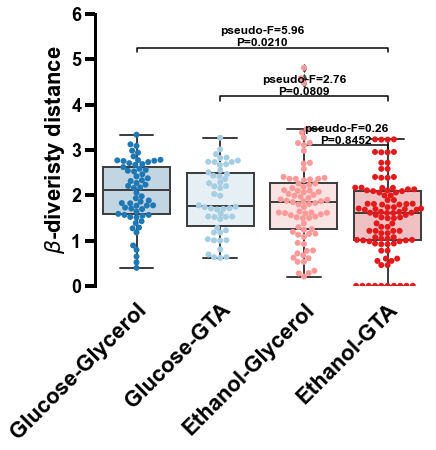

In [95]:
distdf = binabund.distance_matrix.view(DistanceMatrix).to_data_frame()
shared_ = set(mf[mf.treatment == 'Ethanol-GTA'].index) & set(distdf.columns)
distdf = distdf[shared_].stack().reset_index()
map_treat = dict(mf['treatment'])
distdf['treatment'] = [map_treat[x] for x in distdf['level_0']]
distdf['dist'] = distdf[0]

plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 12

fig, ax = plt.subplots(1,1, figsize=(6,5))

# plot
order = ['Glucose-Glycerol','Glucose-GTA',
         'Ethanol-Glycerol','Ethanol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
            'Glucose-GTA':'#a6cee3',
            'Ethanol-Glycerol':'#fb9a99',
            'Ethanol-GTA':'#e31a1c'}

ax = swarmbox_plot(distdf, ax,
                   'dist',
                   'treatment',
                   order,
                   palette=pallette)

# annotate by order
i1 = 2
c1 = order[::-1][0]
for i2, c2 in enumerate(order[::-1][1:]):
    # annot x-axis
    x1, x2 = 2-i2, (i1 + 1)
    # get stat
    p_ = pairwisedf[(pairwisedf['Group 1'] == 'Ethanol-GTA') \
                    & (pairwisedf['Group 2'] == c2)]['q-value']
    f_ = pairwisedf[(pairwisedf['Group 1'] == 'Ethanol-GTA') \
                        & (pairwisedf['Group 2'] == c2)]['pseudo-F']
    p_ = 'pseudo-F=%.2f\nP=%.4f' % (f_, p_)
    # heights
    #y, h, col = distdf[0].max() + .2 * ((i2*5.8)), .1, 'k'
    y, h, col = 3 + .2 * ((i2*5.4)), .1, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12, weight='bold')  

    
    
# relabel
ax.set_ylabel('$\\beta$-diveristy distance',
              fontsize=22,
              weight='bold',
              color='black')
ax.set_xlabel('',
              fontsize=22,
              weight='bold',
              color='black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
ax.tick_params(axis='y', which='major', direction='out', length=6,
               width=2, color='black', zorder=0, reset=True, right=False)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(18)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(2)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.spines['left'].set_bounds(0, 6)
ax.set_ylim(0, 6)
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')

# save the figure to file
plt.savefig('results/figures/metaG-GTA-treatment-distance.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


In [88]:
bin_abund_lr = pd.read_csv('data/bin-grouped-tables/bin-raw-counts.tsv',
                        sep='\t', index_col=0)
bin_abund_lr = bin_abund_lr[set(mf.index) & set(bin_abund_lr.columns)]
bacter = [k for k, v in tax_transctrp[1].items() if 'Bacteroidetes' in v]
lach = [k for k, v in tax_transctrp[1].items() if 'Enterococcaceae' in v]
bin_abund_lr_ = bin_abund_lr + 0.1
abdundlr = pd.DataFrame(np.log(bin_abund_lr_.loc[bacter, :].sum())\
                        - np.log(bin_abund_lr_.loc[lach, :].sum()).sort_index(),
                        columns=['log_ratio_abundance'])
mf_lr = pd.concat([abdundlr, mf], axis=1,sort=False).sort_values('treatment')
mf_lr.loc[~np.isfinite(mf_lr['log_ratio_abundance'].values), 'log_ratio_abundance'] = np.nan


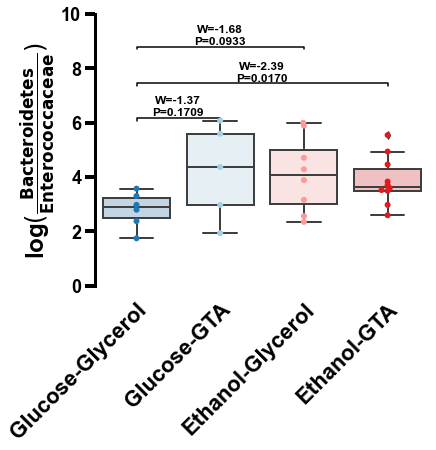

In [93]:
plt.style.use('ggplot')
paper_rc = {'lines.linewidth': 2, 
            'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 12

fig, ax = plt.subplots(1,1, figsize=(6,5))

# plot
order = ['Glucose-Glycerol','Glucose-GTA',
         'Ethanol-Glycerol','Ethanol-GTA']
pallette = {'Glucose-Glycerol':'#1f78b4',
            'Glucose-GTA':'#a6cee3',
            'Ethanol-Glycerol':'#fb9a99',
            'Ethanol-GTA':'#e31a1c'}

ax = swarmbox_plot(mf_lr, ax,
                   'log_ratio_abundance',
                   'treatment',
                   order,
                   palette=pallette)

# annotate by order
i1 = 2
c1 = order[0]
size_ = [1.1,1.5,.5]
for i2, c2 in enumerate(order[1:]):
    # annot x-axis
    x1, x2 = 0, i2 + 1
    # get stat
    
    t_, p_ = ranksums(mf_lr[mf_lr.treatment == 'Glucose-Glycerol']['log_ratio_abundance'].dropna().values,
                      mf_lr[mf_lr.treatment == c2]['log_ratio_abundance'].dropna().values)          
    p_ = 'W=%.2f\nP=%.4f' % (t_, p_)
    # heights
    y, h, col = mf_lr[mf_lr.treatment == c2]['log_ratio_abundance'].max() + 1.5 * (((1.2*i2)*size_[i2])), .1, 'k'
    # plot
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    ax.text((x1+x2)*.5, y+h, p_,
            ha='center', va='bottom',
            color=col, fontsize=12, weight='bold')  

    
# relabel
ax.set_ylabel('log$(\\frac{\\mathbf{%s}}{\\mathbf{%s}})$' % ('Bacteroidetes',
                                         'Enterococcaceae') ,
              fontsize=24,weight='bold',
              color='black')
ax.set_xlabel('',
              fontsize=22,
              weight='bold',
              color='black')
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
ax.tick_params(axis='y', which='major', direction='out', length=6,
               width=2, color='black', zorder=0, reset=True, right=False)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(22)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight("bold")
    tick.set_color("black")
    tick.set_fontsize(18)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(2)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.spines['left'].set_bounds(0, 10)
ax.set_ylim(0, 10)
ax.tick_params(axis='y', colors='black', width=4, length=10)
ax.tick_params(axis='x', colors='black', width=4, length=10)
for sp_i in ax.spines.values():
    sp_i.set_linewidth(3)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
            
# save the figure to file
plt.savefig('results/figures/metaG-GTA-treatment-lr.pdf',
            dpi=600, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()